In [1]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import matplotlib.pyplot as plt
from torchinfo import summary
from torchmetrics.regression import MeanSquaredError
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_14820\1936973876.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = get_tokenizer("basic_english")
label_encoder =LabelEncoder()
class EEPD_Dataset(Dataset):
    def __init__(self):
        
        data = 'data/WASSA23_conv_level_with_labels_train.tsv'

        xy = pd.read_table(data, header=0)
        new_col = []
        for names in xy.columns:
            new_col.append(names.strip())
        xy.columns = new_col
        x, y = xy.loc[:, 'text'], xy.loc[:, ['EmotionalPolarity', 'Emotion', 'Empathy']]
        y['EmotionalPolarity'] = label_encoder.fit_transform(y['EmotionalPolarity'])
        y['Emotion'] = label_encoder.fit_transform(y['Emotion'])
        y['Empathy'] = label_encoder.fit_transform(y['Empathy'])
        # print(y)
        y = np.array(y)


        padd_to_tensor = torchtext.transforms.ToTensor(padding_value=0)
        vocab = build_vocab_from_iterator(self.yield_tokens(x), specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        train_x, train_y = [], []
        for text, label in zip(x, y):
            x_tokens = vocab(tokenizer(text))
            y_label = np.array(label)
            train_x.append(x_tokens)
            train_y.append(y_label)
        train_x = padd_to_tensor(train_x)
        
        self.text = torch.tensor(train_x, dtype=torch.float32).to(device)
        self.label = torch.tensor(train_y, dtype=torch.float32).to(device)
        self.n_samples = x.shape[0]


    def __getitem__(self, index):
        return self.text[index], self.label[index]
    
    def __len__(self):
        return self.n_samples
    
    def yield_tokens(self, text_data):
        for text in text_data:
            yield tokenizer(text)



In [99]:

class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_classes):
        super(DeepNN,self).__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.l1 = nn.Linear(input_size, hidden_size*2)
        self.l2 = nn.Linear(hidden_size*2, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out


for i in range(1):
    feature,label = next(data_iter)
(label[0])



In [ ]:
dataset = EEPD_Dataset()
#train, test split
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset=dataset, lengths=[0.8, 0.2], generator=generator)

learning_rate = 0.01
n_samples = len(train_set)
n_epochs = 5
n_input = len(train_set[0][0])
n_hidden = 100
n_classes = 3
n_batch = 8
n_iterations = math.ceil(n_samples/n_batch)

print(f'n_samples: {n_samples} | n_iterations/batch: {n_iterations}')

train_dataloader = DataLoader(dataset=train_set, batch_size=n_batch, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

data_iter = iter(train_dataloader)


model = DeepNN(n_input, n_hidden, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
print(summary(model, batch_dim=n_batch))

for epoch in range(n_epochs):
    for i, (input, label) in enumerate(train_dataloader):
        #forward
        output = model(input)
        # output = torch.round(output)
        loss = criterion(output, label)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epochs} | step: {i+1}/{n_iterations} | loss: {loss.item():.4f}')
            losses.append(loss)
    
#test
with torch.no_grad():
    error = []
    predictions = []
    for i, (input, label) in enumerate(test_dataloader):
        MSError = MeanSquaredError(num_outputs=3)
        outputs = model(input)
        prediction = torch.round(outputs)
        error.append(MSError(prediction, label))
        predictions.append(prediction)
    print(f'error: {error}')
    MSError.plot()
    # print(error)
    plt.plot(losses)
    plt.show()

C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_14820\1651916091.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.text = torch.tensor(train_x, dtype=torch.float32).to(device)


n_samples: 7021 | n_iterations/batch: 878
Layer (type:depth-idx)                   Param #
DeepNN                                   --
├─ReLU: 1-1                              --
├─Softmax: 1-2                           --
├─Linear: 1-3                            26,800
├─Linear: 1-4                            20,100
├─Linear: 1-5                            303
Total params: 47,203
Trainable params: 47,203
Non-trainable params: 0
epoch: 1/5 | step: 100/878 | loss: 1.1030
epoch: 1/5 | step: 200/878 | loss: 0.9857
epoch: 1/5 | step: 300/878 | loss: 1.0479
epoch: 1/5 | step: 400/878 | loss: 1.1129
epoch: 1/5 | step: 500/878 | loss: 0.9963
epoch: 1/5 | step: 600/878 | loss: 1.1475
epoch: 1/5 | step: 700/878 | loss: 1.0509
epoch: 1/5 | step: 800/878 | loss: 0.9626
epoch: 2/5 | step: 100/878 | loss: 0.9827
epoch: 2/5 | step: 200/878 | loss: 1.0538
epoch: 2/5 | step: 300/878 | loss: 1.1091
epoch: 2/5 | step: 400/878 | loss: 1.1134
epoch: 2/5 | step: 500/878 | loss: 1.1638
epoch: 2/5 | step: 6

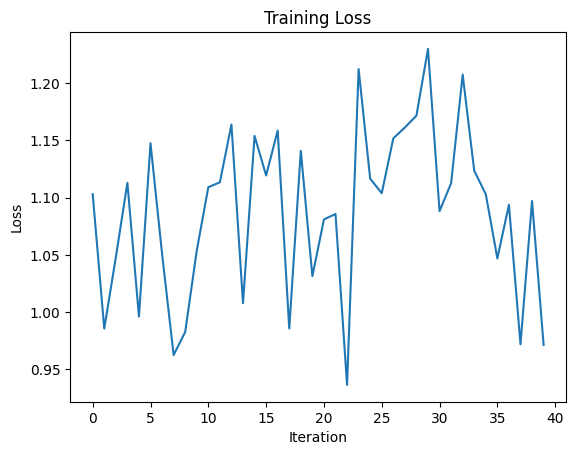

In [114]:
dataset = EEPD_Dataset()
#train, test split
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset=dataset, lengths=[0.8, 0.2], generator=generator)

learning_rate = 0.01
n_samples = len(train_set)
n_epochs = 5
n_input = len(train_set[0][0])
n_hidden = 100
n_classes = 3
n_batch = 8
n_iterations = math.ceil(n_samples/n_batch)

print(f'n_samples: {n_samples} | n_iterations/batch: {n_iterations}')

train_dataloader = DataLoader(dataset=train_set, batch_size=n_batch, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

data_iter = iter(train_dataloader)


model = DeepNN(n_input, n_hidden, n_classes)

# Fixing loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
print(summary(model, batch_dim=n_batch))

for epoch in range(n_epochs):
    for i, (input, label) in enumerate(train_dataloader):
        # forward
        output = model(input)
        loss = criterion(output, torch.argmax(label, dim=1))  # Fix for multi-class classification

        # backward
        optimizer.zero_grad()  # Fix for correct optimizer usage
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epochs} | step: {i+1}/{n_iterations} | loss: {loss.item():.4f}')
            losses.append(loss.item())

# ... (previous code)

# Testing
with torch.no_grad():
    correct = 0
    total = 0
    for i, (input, label) in enumerate(test_dataloader):
        outputs = model(input)
        _, predicted = torch.max(outputs.data, 1)  # Using torch.max for multi-class classification
        total += label.size(0)
        correct += (predicted == torch.argmax(label, dim=1)).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plotting the training loss
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [116]:
# n =torch.round(output[5],)
predictions

[tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., 0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 tensor([[-0., 0., -0.]]),
 t

In [185]:
len(test_dataloader)

1755

In [193]:
data_iter = iter(test_dataloader)
for i in range(10):
    feature,label = next(data_iter)
    print(f'label: {label} \t \t prediction: {predictions[i]}')

label: tensor([[1.3333, 1.3333, 1.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.6667, 1.3333, 2.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[2.0000, 2.3333, 2.3333]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1., 2., 2.]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.0000, 1.6667, 2.0000]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[0.3333, 1.3333, 1.6667]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[1.6667, 2.6667, 2.3333]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[0.6667, 2.0000, 2.0000]], dtype=torch.float64) 	 	 prediction: tensor([[ 0.0482, -0.3499,  2.1861]])
label: tensor([[2.0000, 2.3333, 3.0000]], dtype=torch.float64) 	 	 predictio